In [16]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
# import ftest
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 16})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

import zarr
import dask
from timeit import default_timer as timer
from numba import njit



In [17]:
def test(x, window, missing):
    """Standard Normal Homogeneity Test (SNHT) with a running window
    Wrapper function for numba_snhtmov

    Args:
        x (np.ndarray) : input data
        window (int) : window size (in days)
        missing (int) : allowed missing values (in days)
    Returns:
        np.ndarray : SNHT
    """

    snhtparas = np.asarray([window, missing, 10])
    tsa = np.zeros(x.shape[0])
    tmean = np.zeros(x.shape[0])
    tsquare = np.zeros(x.shape[0])
    count = np.zeros(x.shape[0], dtype=np.int32)

    nc = numba_snhtmov(np.squeeze(np.asarray(x)),
                       tsa,
                       snhtparas,
                       count,
                       tmean,
                       tsquare)
    return tsa, nc


@njit
def numba_snhtmov(t, tsa, snhtparas, count, tmean, tsquare):
    """Standard Normal Homogeneity Test Moving Window

    t         = np.random.randn(1000)
    snhtparas = np.asarray([100,50,10])
    tsa       = np.zeros(1000)
    tmean     = np.zeros(1000)
    tsquare   = np.zeros(1000)
    count     = np.zeros(1000,dtype=np.int32)

    Output: tsa
    """
    n = snhtparas[0]
    max_miss = snhtparas[1]
    # ninc=snhtparas[2]

    ni = t.shape[0]
    good = 0
    tmean[0] = 0.
    tsquare[0] = 0.
    nancut = []
    for j in range(ni):
        count[j] = 0
        # compare_lists if nan ?
        if t[j] == t[j]:
            if good > 0:
                tmean[good] = tmean[good - 1] + t[j]
                tsquare[good] = tsquare[good - 1] + t[j] * t[j]
            else:
                tmean[good] = t[j]
                tsquare[good] = t[j] * t[j]
            good += 1
            nancut.append(0)
        else:
            nancut.append(1)
            if good > 0:
                tmean[good] = tmean[good - 1] + tmean[good - 2]
                tsquare[good] = tsquare[good - 1] + tsquare[good - 2]
            
        if good > 0:
            count[j] = good - 1

    if good > n - 2 * max_miss:
        rm = int(n / 2)  # needs to be an integer
        # k 1460/2=730 - 650=80, n-80
        for k in range(rm - max_miss, ni - (rm - max_miss)):
            xm = k - rm  # 80-730
            if xm < 0:
                xm = 0
            xp = k + rm
            if xp > ni - 1:
                xp = ni - 1
            if (count[k] - count[xm] > rm - max_miss) and (count[xp] - count[k] > rm - max_miss):
                x = (tmean[count[k]] - tmean[count[xm]]) / (count[k] - count[xm])  # Mittelwert 1 Periode
                y = (tmean[count[xp]] - tmean[count[k]]) / (count[xp] - count[k])  # Mittelwert 2 Periode
                xy = (tmean[count[xp]] - tmean[count[xm]]) / (count[xp] - count[xm])  # Mittelwert ganze Periode

                sig = (tsquare[count[xp]] - tsquare[count[xm]]) / (count[xp] - count[xm])  # t*t ganze Periode
                if sig > xy * xy:
                    sig = np.sqrt(sig - xy * xy)  # standard deviation of the whole window
                    # n1 * (m1-m)**2 + n2 * (m2-m)**2 / stddev
                    tsa[k] = ((count[k] - count[xm]) * (x - xy) * (x - xy) + (count[xp] - count[k]) * (y - xy) * (
                            y - xy)) / (sig * sig)
                else:
                    tsa[k] = 0.
    return nancut

In [18]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = numpy.radians(lon1)
    lat1 = numpy.radians(lat1)
    lon2 = numpy.radians(lon2)
    lat2 = numpy.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

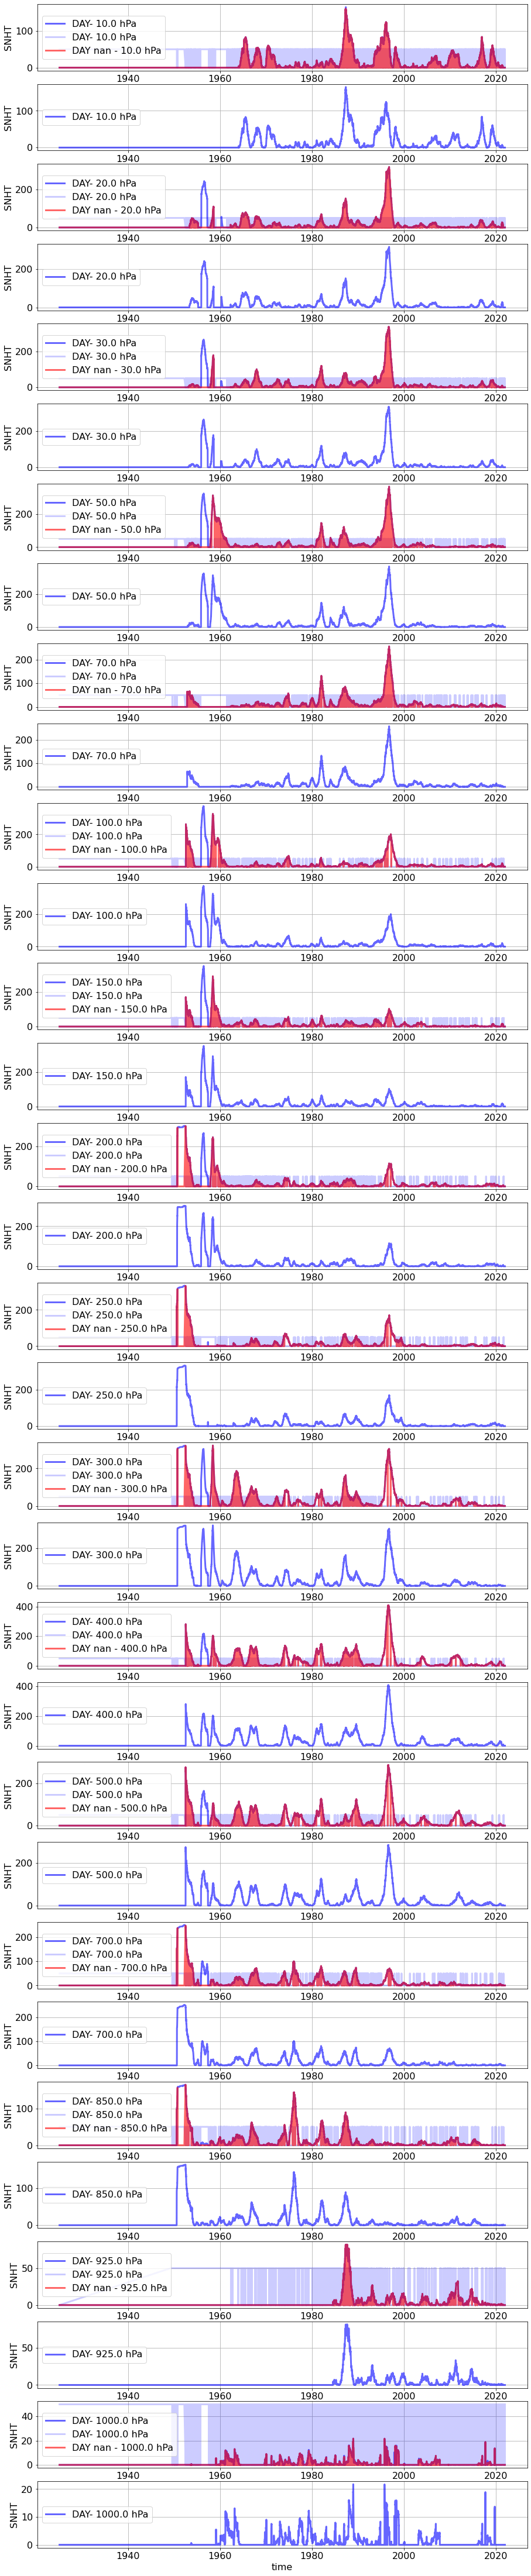

In [101]:
stdplevs = [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0]
files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged*')
df = xr.open_dataset(files[0])

window = 1460  # means 4 years on daily basis
missing = 600

df_night = df[dict(hour=0)]
df_day = df[dict(hour=1)]

fig, ax = maplt.subplots(len(stdplevs)*2, 1, figsize = (15,80))
for i in range(len(stdplevs)):
    df_day_snht = df_day[dict(pressure=i)]
    df_night_snht = df_night[dict(pressure=i)]
    df1 = df_day_snht.to_dataframe()
    
    for yr in [2010, 2011]:
        for mn in [6, 7, 8]: # range(1,12,1): #
            df1 = df1[df1.datum < str(yr)+"-"+str(mn)].append(df1[df1.datum >= str(yr)+"-"+str(mn+1)])

#     for yr in [2015, 2016, 2017, 2018]:
#         df1 = df1[df1.datum < str(yr)].append(df1[df1.datum >= str(1+yr)])

    snht_day,nc= test(np.array(df1.era5_fgdep), window, missing)
    
#     snht_night = test(np.array(df_night_snht.era5_fgdep), window, missing)
#     snht_diff_dn = test(np.array(df_day_snht.era5_fgdep)-np.array(df_night_snht.era5_fgdep), window, missing)
#     snht_diff_dn_t = test(np.array(df_day_snht.temperatures)-np.array(df_night_snht.temperatures), window, missing)
    
    ax[i*2].plot(np.array(df1.datum),snht_day,color = 'blue', alpha = 0.6, label='DAY- ' + str(stdplevs[i]) + ' hPa', )
    ax[i*2].plot(np.array(df1.datum),np.array(nc)*50,color = 'blue', alpha = 0.2, label='DAY- ' + str(stdplevs[i]) + ' hPa', )
    
    snht_day_corr = snht_day
    snht_day_corr[np.array(nc) == 1] = 0
    ax[i*2].plot(np.array(df1.datum),snht_day_corr,color = 'red', alpha = 0.6, label='DAY nan - ' + str(stdplevs[i]) + ' hPa', )
#     ax[i*2].plot(np.array(df1.datum),df1.era5_fgdep,color = 'green', alpha = 0.6, label='DAY era5_fgdep - ' + str(stdplevs[i]) + ' hPa', )
#     ax[i].plot(np.array(df_night_snht.datum),snht_night,color = 'orange', alpha = 0.6, label='NIGHT- ' + str(stdplevs[i]) + ' Pa', )
#     ax[i].plot(np.array(df_day_snht.datum),snht_diff_dn,color = 'purple', alpha = 0.6, label='DIFF - ' + str(stdplevs[i]) + ' Pa', )
#     ax[i].plot(np.array(df_day_snht.datum),snht_diff_dn_t,color = 'red', alpha = 0.4, label='DIFF T- ' + str(stdplevs[i]) + ' Pa', )
#     mean_snht = (np.array(snht_day) + np.array(snht_night) + np.array(snht_diff_dn) + np.array(snht_diff_dn_t))/4.
#     ax[i].plot(np.array(df_day_snht.datum),mean_snht,color = 'black', alpha = 0.3, linewidth = 12, label='MEAN - ' + str(stdplevs[i]) + ' Pa', )
    ax[i*2].set_ylabel('SNHT')
    ax[i*2].set_xlabel('time')
    ax[i*2].legend(loc='center left')
    ax[i*2].grid()
    
    snht_day_o,nc= test(np.array(df_day_snht.era5_fgdep), window, missing)
    ax[i*2+1].plot(np.array(df_day_snht.datum),snht_day_o,color = 'blue', alpha = 0.6, label='DAY- ' + str(stdplevs[i]) + ' hPa', )
    ax[i*2+1].set_ylabel('SNHT')
    ax[i*2+1].set_xlabel('time')
    ax[i*2+1].legend(loc='center left')
    ax[i*2+1].grid()
    
maplt.show()
maplt.close()


# day_snht_700_200 = test(np.array(df_day[dict(pressure=12)].temperatures) - np.array(df_day[dict(pressure=7)].temperatures), window, missing)
# day_snht_200_100 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=5)].temperatures), window, missing) 
# day_snht_200_50 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=3)].temperatures), window, missing) 
# day_snht_200_30 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=2)].temperatures), window, missing) 

# fig, ax = maplt.subplots(1, figsize = (15,5))
# ax.plot(np.array(df_day.datum),day_snht_700_200, color = 'blue', alpha = 0.3, label='700 - 200 hPa', )
# ax.plot(np.array(df_day.datum),day_snht_200_100, color = 'green', alpha = 0.3, label='200 - 100 hPa', )
# ax.plot(np.array(df_day.datum),day_snht_200_50, color = 'red', alpha = 0.3, label='200 - 50 hPa', )
# ax.plot(np.array(df_day.datum),day_snht_200_30, color = 'black', alpha = 0.3, label='200 - 30 hPa', )
# mean_day = (np.array(day_snht_700_200) + np.array(day_snht_200_100) + np.array(day_snht_200_50) + np.array(day_snht_200_30))/4.
# ax.plot(np.array(df_day.datum),mean_day, color = 'black', alpha = 0.8, linewidth = 3, label='MEAN', )
# ax.set_ylabel('SNHT - DAY')
# ax.set_xlabel('time')
# ax.legend()
# ax.grid()
# maplt.show()
# maplt.close()

# night_snht_700_200 = test(np.array(df_night[dict(pressure=12)].temperatures) - np.array(df_night[dict(pressure=7)].temperatures), window, missing)
# night_snht_200_100 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=5)].temperatures), window, missing) 
# night_snht_200_50 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=3)].temperatures), window, missing) 
# night_snht_200_30 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=2)].temperatures), window, missing) 

# fig, ax = maplt.subplots(1, figsize = (15,5))
# ax.plot(np.array(df_night.datum),night_snht_700_200, color = 'blue', alpha = 0.3, label='700 - 200 hPa', )
# ax.plot(np.array(df_night.datum),night_snht_200_100, color = 'green', alpha = 0.3, label='200 - 100 hPa', )
# ax.plot(np.array(df_night.datum),night_snht_200_50, color = 'red', alpha = 0.3, label='200 - 50 hPa', )
# ax.plot(np.array(df_night.datum),night_snht_200_30, color = 'black', alpha = 0.3, label='200 - 30 hPa', )
# mean_night = (np.array(night_snht_700_200) + np.array(night_snht_200_100) + np.array(night_snht_200_50) + np.array(night_snht_200_30))/4.
# ax.plot(np.array(df_night.datum),mean_night, color = 'black', alpha = 0.8, linewidth = 3, label='MEAN', )

# ax.set_ylabel('SNHT - NIGHT')
# ax.set_xlabel('time')
# ax.legend()
# ax.grid()
# maplt.show()
# maplt.close()

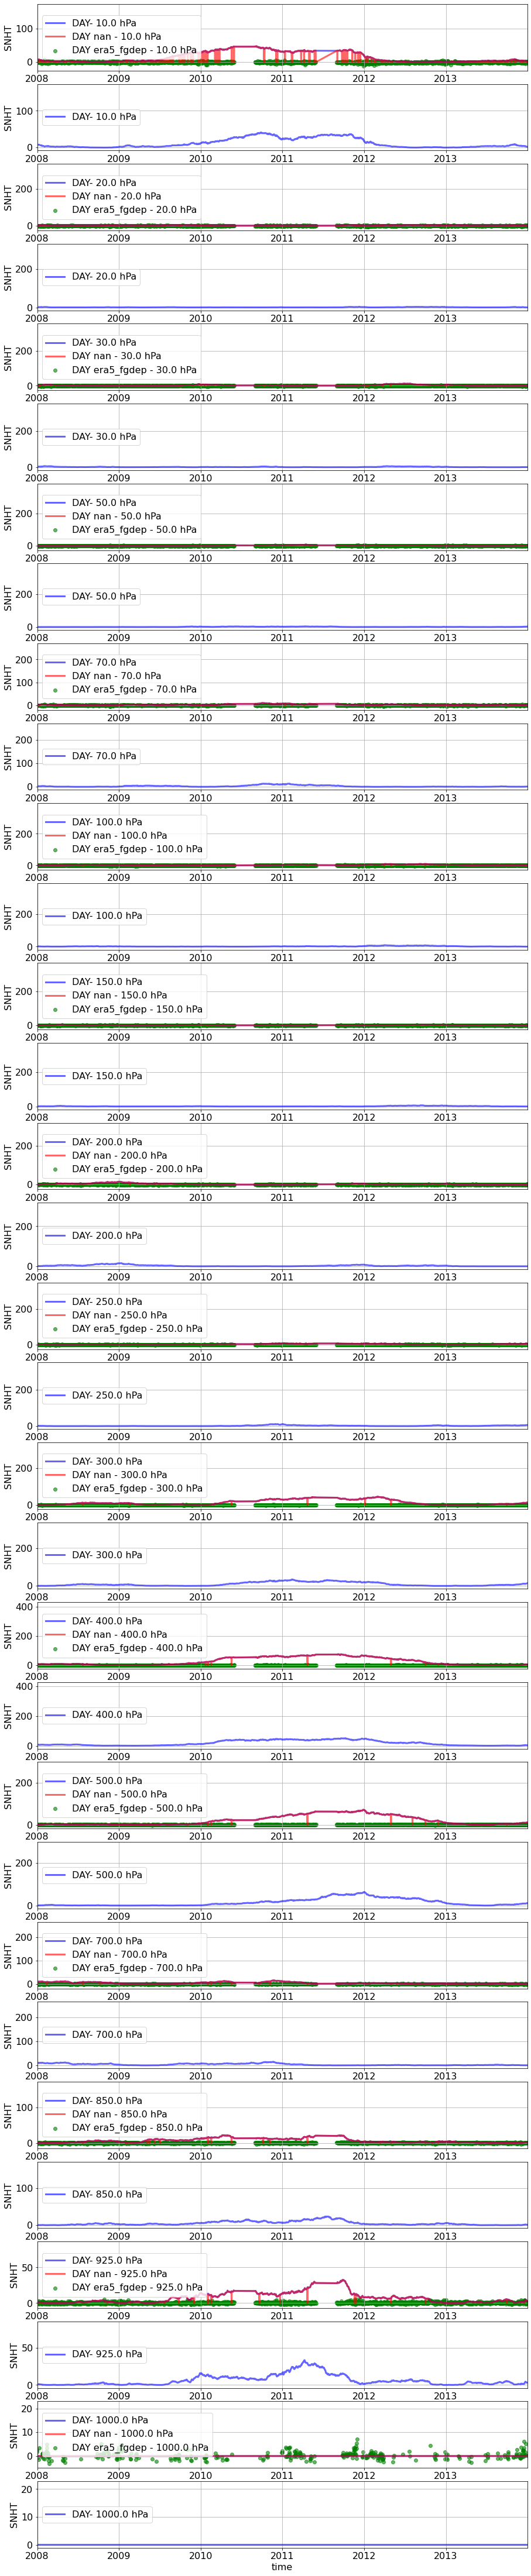

In [114]:
stdplevs = [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0]
files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged*')
df = xr.open_dataset(files[0])

window = 1460  # means 4 years on daily basis
missing = 600

df_night = df[dict(hour=0)]
df_day = df[dict(hour=1)]

fig, ax = maplt.subplots(len(stdplevs)*2, 1, figsize = (15,80))
for i in range(len(stdplevs)):
    df_day_snht = df_day[dict(pressure=i)]
    df_night_snht = df_night[dict(pressure=i)]
    df1 = df_day_snht.to_dataframe()
    
    for yr in [2010, 2011]:
        for mn in [6, 7, 8]: # range(1,12,1): #
            df1 = df1[df1.datum < str(yr)+"-"+str(mn)].append(df1[df1.datum >= str(yr)+"-"+str(mn+1)])

#     for yr in [2015, 2016, 2017, 2018]:
#         df1 = df1[df1.datum < str(yr)].append(df1[df1.datum >= str(1+yr)])

    snht_day,nc= test(np.array(df1.era5_fgdep), window, missing)
    
#     snht_night = test(np.array(df_night_snht.era5_fgdep), window, missing)
#     snht_diff_dn = test(np.array(df_day_snht.era5_fgdep)-np.array(df_night_snht.era5_fgdep), window, missing)
#     snht_diff_dn_t = test(np.array(df_day_snht.temperatures)-np.array(df_night_snht.temperatures), window, missing)
    
    ax[i*2].plot(np.array(df1.datum),snht_day,color = 'blue', alpha = 0.6, label='DAY- ' + str(stdplevs[i]) + ' hPa', )
#     ax[i*2].plot(np.array(df1.datum),np.array(nc)*50,color = 'blue', alpha = 0.2, label='DAY- ' + str(stdplevs[i]) + ' hPa', )
    
    snht_day_corr = snht_day
    snht_day_corr[np.array(nc) == 1] = 0
    ax[i*2].plot(np.array(df1.datum),snht_day_corr,color = 'red', alpha = 0.6, label='DAY nan - ' + str(stdplevs[i]) + ' hPa', )
    ax[i*2].scatter(np.array(df1.datum),df1.era5_fgdep,color = 'green', alpha = 0.6, label='DAY era5_fgdep - ' + str(stdplevs[i]) + ' hPa', )
#     ax[i].plot(np.array(df_night_snht.datum),snht_night,color = 'orange', alpha = 0.6, label='NIGHT- ' + str(stdplevs[i]) + ' Pa', )
#     ax[i].plot(np.array(df_day_snht.datum),snht_diff_dn,color = 'purple', alpha = 0.6, label='DIFF - ' + str(stdplevs[i]) + ' Pa', )
#     ax[i].plot(np.array(df_day_snht.datum),snht_diff_dn_t,color = 'red', alpha = 0.4, label='DIFF T- ' + str(stdplevs[i]) + ' Pa', )
#     mean_snht = (np.array(snht_day) + np.array(snht_night) + np.array(snht_diff_dn) + np.array(snht_diff_dn_t))/4.
#     ax[i].plot(np.array(df_day_snht.datum),mean_snht,color = 'black', alpha = 0.3, linewidth = 12, label='MEAN - ' + str(stdplevs[i]) + ' Pa', )
    ax[i*2].set_ylabel('SNHT')
    ax[i*2].set_xlabel('time')
    ax[i*2].set_xlim([datetime.date(2008, 1, 1), datetime.date(2013, 12, 31)])
    ax[i*2].legend(loc='center left')
    ax[i*2].grid()
    
    snht_day_o,nc= test(np.array(df_day_snht.era5_fgdep), window, missing)
    ax[i*2+1].plot(np.array(df_day_snht.datum),snht_day_o,color = 'blue', alpha = 0.6, label='DAY- ' + str(stdplevs[i]) + ' hPa', )
    ax[i*2+1].set_ylabel('SNHT')
    ax[i*2+1].set_xlabel('time')
    ax[i*2+1].set_xlim([datetime.date(2008, 1, 1), datetime.date(2013, 12, 31)])
    ax[i*2+1].legend(loc='center left')
    ax[i*2+1].grid()
    
maplt.show()
maplt.close()


# day_snht_700_200 = test(np.array(df_day[dict(pressure=12)].temperatures) - np.array(df_day[dict(pressure=7)].temperatures), window, missing)
# day_snht_200_100 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=5)].temperatures), window, missing) 
# day_snht_200_50 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=3)].temperatures), window, missing) 
# day_snht_200_30 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=2)].temperatures), window, missing) 

# fig, ax = maplt.subplots(1, figsize = (15,5))
# ax.plot(np.array(df_day.datum),day_snht_700_200, color = 'blue', alpha = 0.3, label='700 - 200 hPa', )
# ax.plot(np.array(df_day.datum),day_snht_200_100, color = 'green', alpha = 0.3, label='200 - 100 hPa', )
# ax.plot(np.array(df_day.datum),day_snht_200_50, color = 'red', alpha = 0.3, label='200 - 50 hPa', )
# ax.plot(np.array(df_day.datum),day_snht_200_30, color = 'black', alpha = 0.3, label='200 - 30 hPa', )
# mean_day = (np.array(day_snht_700_200) + np.array(day_snht_200_100) + np.array(day_snht_200_50) + np.array(day_snht_200_30))/4.
# ax.plot(np.array(df_day.datum),mean_day, color = 'black', alpha = 0.8, linewidth = 3, label='MEAN', )
# ax.set_ylabel('SNHT - DAY')
# ax.set_xlabel('time')
# ax.legend()
# ax.grid()
# maplt.show()
# maplt.close()

# night_snht_700_200 = test(np.array(df_night[dict(pressure=12)].temperatures) - np.array(df_night[dict(pressure=7)].temperatures), window, missing)
# night_snht_200_100 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=5)].temperatures), window, missing) 
# night_snht_200_50 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=3)].temperatures), window, missing) 
# night_snht_200_30 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=2)].temperatures), window, missing) 

# fig, ax = maplt.subplots(1, figsize = (15,5))
# ax.plot(np.array(df_night.datum),night_snht_700_200, color = 'blue', alpha = 0.3, label='700 - 200 hPa', )
# ax.plot(np.array(df_night.datum),night_snht_200_100, color = 'green', alpha = 0.3, label='200 - 100 hPa', )
# ax.plot(np.array(df_night.datum),night_snht_200_50, color = 'red', alpha = 0.3, label='200 - 50 hPa', )
# ax.plot(np.array(df_night.datum),night_snht_200_30, color = 'black', alpha = 0.3, label='200 - 30 hPa', )
# mean_night = (np.array(night_snht_700_200) + np.array(night_snht_200_100) + np.array(night_snht_200_50) + np.array(night_snht_200_30))/4.
# ax.plot(np.array(df_night.datum),mean_night, color = 'black', alpha = 0.8, linewidth = 3, label='MEAN', )

# ax.set_ylabel('SNHT - NIGHT')
# ax.set_xlabel('time')
# ax.legend()
# ax.grid()
# maplt.show()
# maplt.close()

In [91]:
1,2
3,4
5,6
for i in range(1,11):
    print(i*2-1, i*2)

1 2
3 4
5 6
7 8
9 10
11 12
13 14
15 16
17 18
19 20


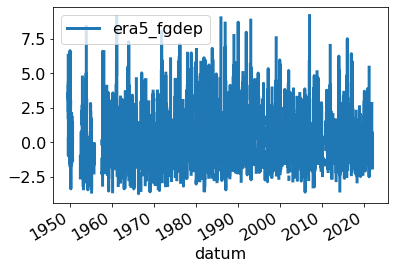

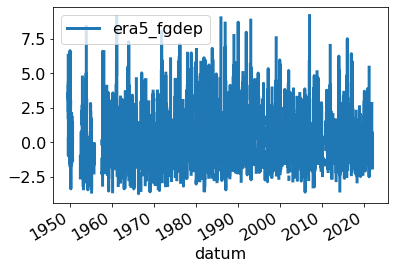

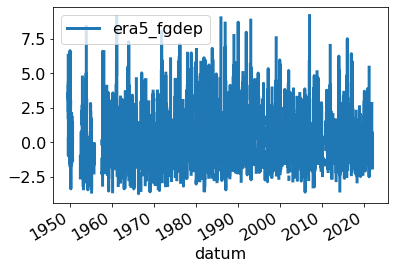

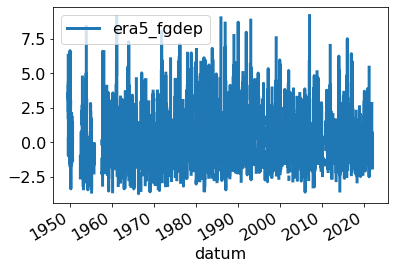

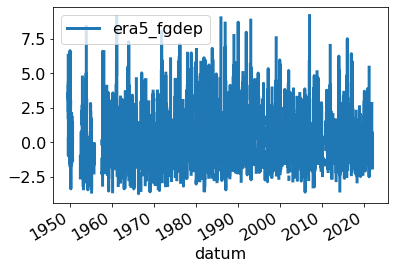

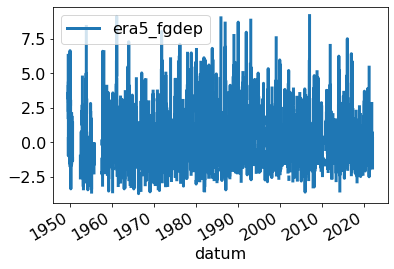

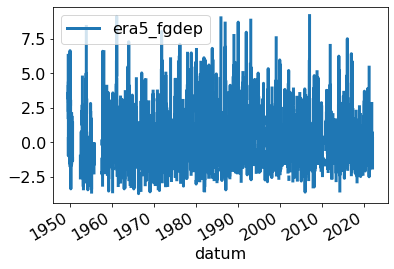

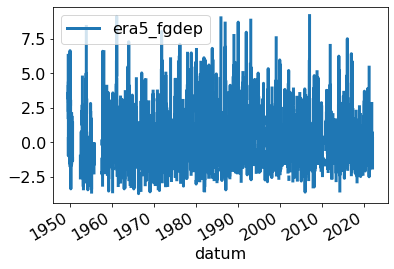

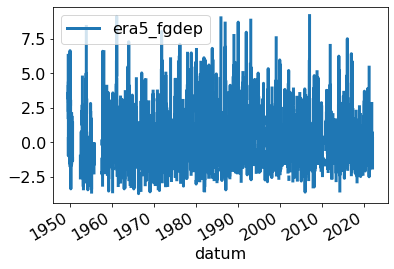

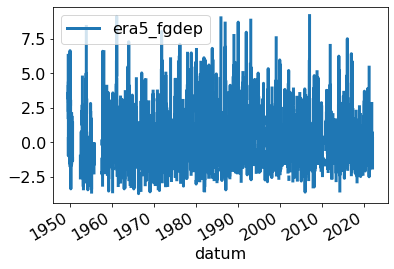

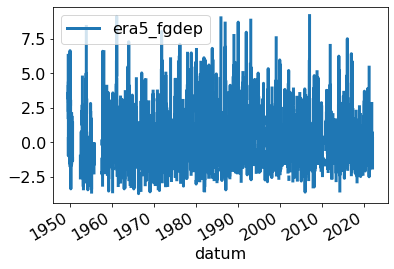

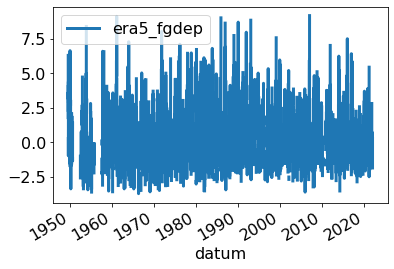

In [85]:
df1 = df_day_snht.to_dataframe()
for yr in ['2015', '2016']:
    for mn in ['06', '07', '08','09','10','11']:
        df1 = df1[df1.datum < yr+"-"+mn].append(df1[df1.datum >= yr+"-"+str(int(mn)+1)])
        df1.plot(x='datum', y='era5_fgdep')

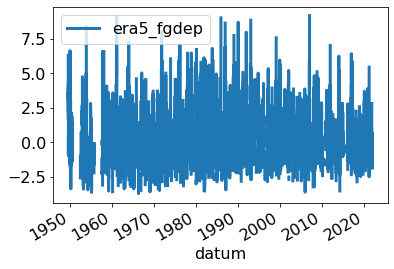

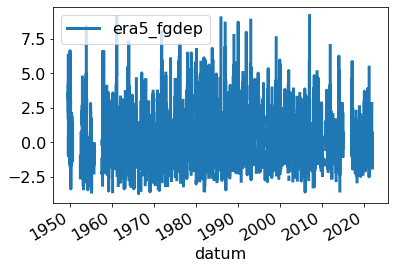

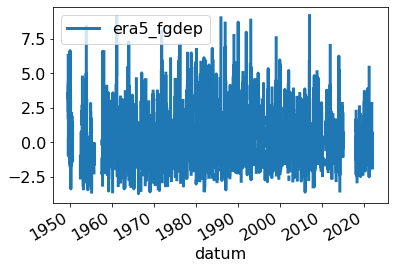

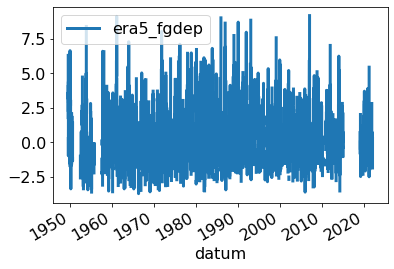

In [86]:
df1 = df_day_snht.to_dataframe()
for yr in [2015, 2016, 2017, 2018]:
        df1 = df1[df1.datum < str(yr)].append(df1[df1.datum >= str(1+yr)])
        df1.plot(x='datum', y='era5_fgdep')

In [79]:
df1#.plot(y='era5_fgdep', x='datum')

,,hour,press,datum,temperatures,era5_fgdep,bias_estimate,lat,lon,hours
time,station,,,,,,,,,
0,0,12,10.0,1925-01-24,NaN,NaN,0.0,48.25,16.370001,9
1,0,12,10.0,1949-04-08,NaN,NaN,0.0,48.25,16.370001,0
2,0,12,10.0,1949-04-12,NaN,NaN,0.0,48.25,16.370001,0
3,0,12,10.0,1949-04-13,NaN,NaN,0.0,48.25,16.370001,0
4,0,12,10.0,1949-06-21,NaN,NaN,0.0,48.25,16.370001,0
...,...,...,...,...,...,...,...,...,...,...
25685,0,12,10.0,2021-12-27,228.240005,-0.045887,0.0,48.25,16.370001,11
25686,0,12,10.0,2021-12-28,225.910004,-1.100870,0.0,48.25,16.370001,11
25687,0,12,10.0,2021-12-29,226.850006,-2.834952,0.0,48.25,16.370001,11


In [72]:
df1 = df_day.to_dataframe()
for i in ['2015', '2016']:
    for j in ['06', '07', '08']:
        df1 = df1[df1.datum < i+"-"+j].append(df1[df1.datum >= i+"-"+str(int(j)+1)])


<AxesSubplot:xlabel='datum'>

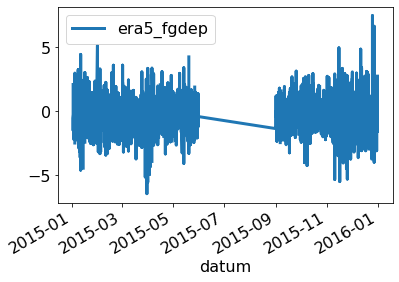

In [73]:
df1[df1.datum > '2015'][df1.datum < '2016'].plot(y='era5_fgdep', x='datum')

<AxesSubplot:xlabel='datum'>

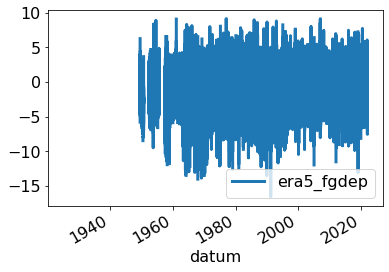

In [50]:
df1.plot(y='era5_fgdep', x='datum')

In [20]:
# # creating input files for ACMANT4

# from datetime import date, timedelta

# def daterange(start_date, end_date):
#     for n in range(int((end_date - start_date).days)):
#         yield start_date + timedelta(n)
        
# def last_day_of_month(any_day):
#     next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
#     return next_month - datetime.timedelta(days=next_month.day)

# lines = []
# lines.append(str(df.unique_source_identifier))
# for yr in range(1950,1951,1):
#     for mn in range(1,3,1):
#         line = str(yr) + ' ' + str(mn)
#         start_date = date(yr, mn, 1)
#         end_date = last_day_of_month(start_date)
#         for single_date in daterange(start_date, end_date + datetime.timedelta(days=1)):
#             line = line + ' ' + 


In [6]:
testdf

NameError: name 'testdf' is not defined

In [ ]:
# creating input files for ACMANT4

testdf = df_day.to_dataframe()
snumb = 1

from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    return next_month - datetime.timedelta(days=next_month.day)

for i in testdf.press.drop_duplicates():
    pdf = testdf[testdf.press == i]
    lines = []
    lines.append(str(df.unique_source_identifier) + '\n')
    for yr in range(1950,2022,1):
        print(yr)
        for mn in range(1,13,1):
            line = str(yr) + '\t' + str(mn)
            start_date = date(yr, mn, 1)
            end_date = last_day_of_month(start_date)
            for single_date in daterange(start_date, end_date + datetime.timedelta(days=1)):
                try:
                    temp = float(pdf[pdf.datum == single_date.strftime("%Y-%m-%d")].temperatures)
                    if temp == temp:
                        line = line + '\t' + str(temp-273.15)[:6]
                    else:
                        line = line + '\t' + '-999.9'
                except:
                    line = line + '\t' + '-999.9'
            lines.append(line + '\n')
    with open('S'+str(snumb).rjust(4, '0')+str(int(i)).rjust(4, '0')+"t.txt","w+") as f:
        f.writelines(lines)

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005


In [ ]:
with open("text.txt","w+") as f:
    f.writelines(lines)

In [13]:
str(int(50.0)).rjust(5, '0')

'00050'

In [74]:
single_date

datetime.date(2020, 1, 1)

In [49]:
# ftest.snhteqsamp2y(
#     test= ,
#     ref= ,
#     ni= ,
#     istartorig= 0, #gets overwritten in the function
#     istoporig= 0, #gets overwritten in the function
#     maxlen= ,
#     increment= ,
#     miss_val= np.nan,
#     max_miss= ,
#     critical_dates= ,
#     ncritical= ,
#     tsa=, 
#     plus= ,
#     minus= ,
#     prms= ,
#     mrms= ,
#     pcount= ,
#     mcount= 
#     )

In [179]:
# files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/*/feedbackmerged*')
# latlon = {}
# for i in files:
#     df = xr.open_dataset(i)
#     latlon[i]=[float(df.lat[0]), float(df.lon[0])]
# with open("stat_latlon.p", "wb") as output_file:
#     pickle.dump(latlon, output_file)
    
# with open('stat_latlon.p', "rb") as input_file:
#     latlon = pickle.load(input_file)
# distdict = {}
# for i in latlon:
#     lat = latlon[i][0]
#     lon = latlon[i][1]
#     dists = []
#     for j in latlon:
#         dists.append([j, haversine(lat1=lat, lon1=lon, lat2=latlon[j][0], lon2=latlon[j][1])])
#     distdict[i]=dists
    
# ct = 0
# out_to_file = {}
# for i in distdict:
#     print(i)
#     save_to_dict = []
#     stats, dists = np.array(distdict[i]).transpose()
#     dists = np.array(dists).astype(float)
#     out = [x for x in sorted(zip(dists, stats))]
#     for j in range(len(out))[:10]: # only save the 10 nearest stations includin self
#         save_to_dict.append([out[j][1], out[j][0], latlon[out[j][1]]])
#     out_to_file[i] = save_to_dict
# #     ct+=1
# #     if ct >5:break
# with open("nearest_stations.p", "wb") as output_file:
#     pickle.dump(out_to_file, output_file)

In [182]:
# files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/*/feedbackmerged*')
# window = 1460  # means 4 years on daily basis
# latlon = {}
# for i in files:
#     df = xr.open_dataset(i)
#     if len(df.time) >= window:
#         latlon[i]=[float(df.lat[0]), float(df.lon[0])]
# # with open("stat_latlon.p", "wb") as output_file:
# #     pickle.dump(latlon, output_file)
    
# # with open('stat_latlon.p', "rb") as input_file:
# #     latlon = pickle.load(input_file)
# distdict = {}
# for i in latlon:
#     lat = latlon[i][0]
#     lon = latlon[i][1]
#     dists = []
#     for j in latlon:
#         dists.append([j, haversine(lat1=lat, lon1=lon, lat2=latlon[j][0], lon2=latlon[j][1])])
#     distdict[i]=dists
    
# ct = 0
# out_to_file = {}
# for i in distdict:
#     print(i)
#     save_to_dict = []
#     stats, dists = np.array(distdict[i]).transpose()
#     dists = np.array(dists).astype(float)
#     out = [x for x in sorted(zip(dists, stats))]
#     for j in range(len(out))[:10]: # only save the 10 nearest stations includin self
#         save_to_dict.append([out[j][1], out[j][0], latlon[out[j][1]]])
#     out_to_file[i] = save_to_dict
# #     ct+=1
# #     if ct >5:break
# with open("nearest_stations_with_snht.p", "wb") as output_file:
#     pickle.dump(out_to_file, output_file)

/users/staff/leo/fastscratch/rise/1.0/exp03/003953/feedbackmerged003953.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/038507/feedbackmerged038507.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/044292/feedbackmerged044292.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/050557/feedbackmerged050557.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/061024/feedbackmerged061024.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/008495/feedbackmerged008495.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/058847/feedbackmerged058847.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/091413/feedbackmerged091413.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/003602/feedbackmerged003602.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/091701/feedbackmerged091701.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/070291/feedbackmerged070291.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/003995/feedbackmerged003995.nc
/users/staff/leo/fastscratch/rise/1.0/exp03/042398/feedbackmerged042398.nc
/users/staff/leo/fastscra

In [183]:
with open('nearest_stations.p', "rb") as input_file:
    nearest_stations = pickle.load(input_file)

In [184]:
with open('nearest_stations_with_snht.p', "rb") as input_file:
    nearest_stations_with_snht = pickle.load(input_file)

In [186]:
vie = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/*11035*/feedbackmerged*')[0]
print(vie)
print()
display(nearest_stations[vie])
print()
display(nearest_stations_with_snht[vie])

/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged011035.nc



[['/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged011035.nc',
  0.0,
  [48.25, 16.3700008392334]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011182/feedbackmerged011182.nc',
  48.01469613871976,
  [47.83000183105469, 16.219999313354492]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011723/feedbackmerged011723.nc',
  94.10032468036759,
  [49.08000183105469, 16.6200008392334]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011171/feedbackmerged011171.nc',
  94.60177544324897,
  [47.77000045776367, 15.319999694824219]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/112812/feedbackmerged112812.nc',
  112.5165167740033,
  [47.25, 16.600000381469727]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/012822/feedbackmerged012822.nc',
  115.10454888403122,
  [47.70000076293945, 17.68000030517578]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011192/feedbackmerged011192.nc',
  122.3714640976224,
  [47.150001525878906, 16.31999969482422]],
 ['/users/staff/leo/fastscr

[['/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged011035.nc',
  0.0,
  [48.25, 16.3700008392334]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011723/feedbackmerged011723.nc',
  94.10032468036759,
  [49.08000183105469, 16.6200008392334]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011747/feedbackmerged011747.nc',
  144.9442787908561,
  [49.45249938964844, 17.134700775146484]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011240/feedbackmerged011240.nc',
  155.1518973301889,
  [47.0, 15.449999809265137]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011010/feedbackmerged011010.nc',
  162.19492839537813,
  [48.22999954223633, 14.180000305175781]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/012843/feedbackmerged012843.nc',
  228.7416985740462,
  [47.43330001831055, 19.183300018310547]],
 ['/users/staff/leo/fastscratch/rise/1.0/exp03/011520/feedbackmerged011520.nc',
  255.5683749269902,
  [50.099998474121094, 14.283300399780273]],
 ['/users/staff/leo/fastsc

In [8]:
stdplevs = [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0]
window = 1460  # means 4 years on daily basis
missing = 600

LOG_EVERY_N = 50

files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/*/feedbackmerged*')
night_save = {}
night_times = {}
day_save = {}
day_times = {}
for i in stdplevs:
    night_save[i]=[]
    night_times[i]=[]
    day_save[i]=[]
    day_times[i]=[]
t0 = time.time()
for j in range(len(files)):
    if (j % LOG_EVERY_N) == 0: print(j)
    try:
        df = xr.open_dataset(files[j])
        for i in range(len(stdplevs)):
            df_new = df[dict(pressure=i)]
            if len(df_new.time) >= window:
                df_snht = df_new[dict(hour=0)]
                snht = test(np.array(df_snht.temperatures), window, missing)
                night_save[stdplevs[i]].append(np.array(snht))
                night_times[stdplevs[i]].append(np.array(df_snht.datum))

                df_snht = df_new[dict(hour=1)]
                snht = test(np.array(df_snht.temperatures), window, missing)
                day_save[stdplevs[i]].append(np.array(snht))
                day_times[stdplevs[i]].append(np.array(df_snht.datum))
    except:
        print('xxxxxxxxx', files[j], j)
        break
print(time.time()-t0)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
80.75471138954163


10.0


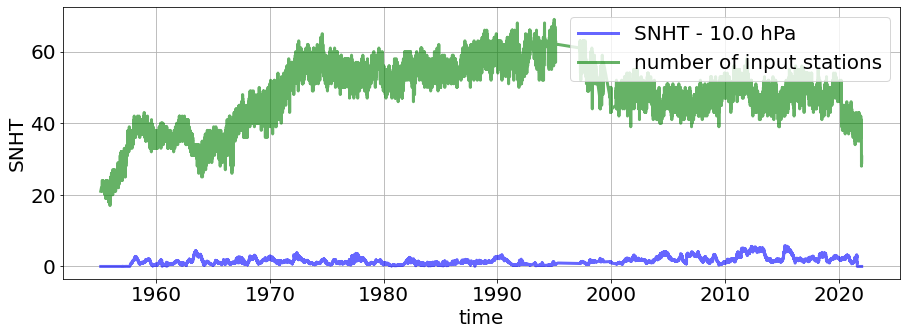

20.0


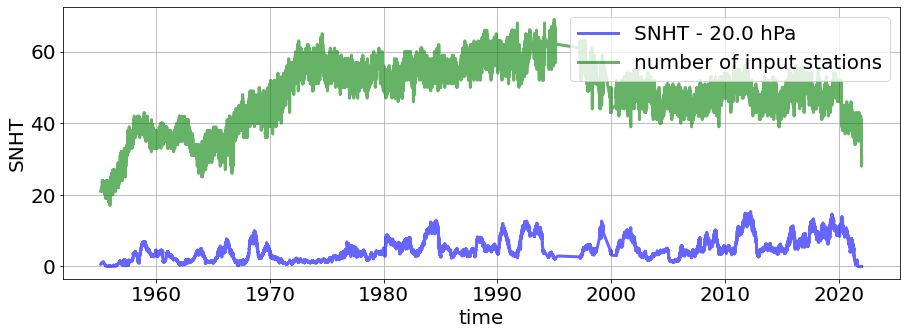

30.0


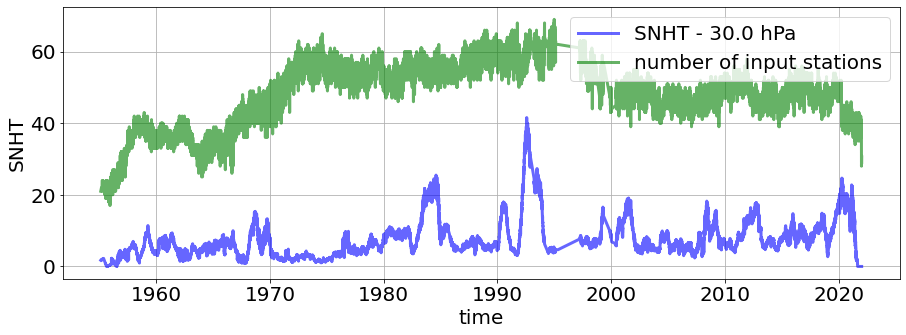

50.0


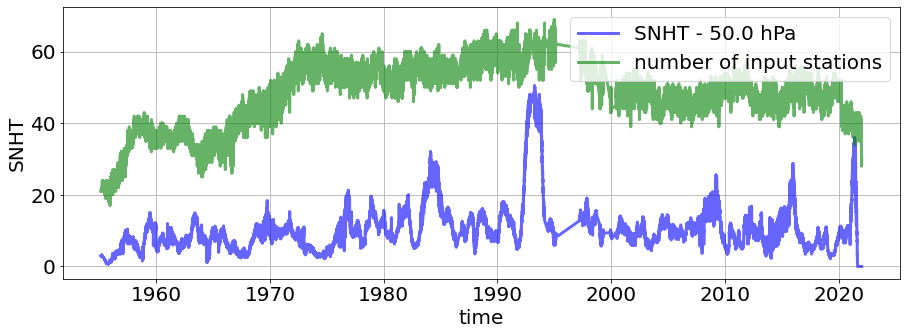

70.0


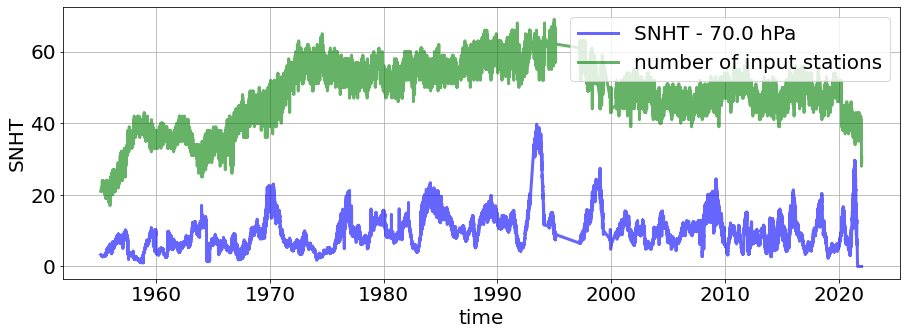

100.0


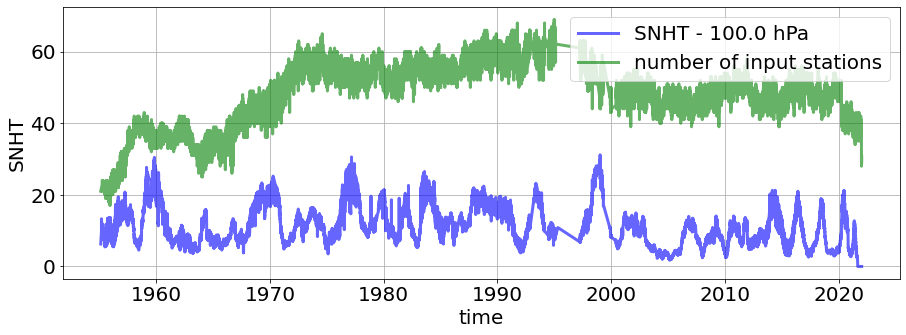

150.0


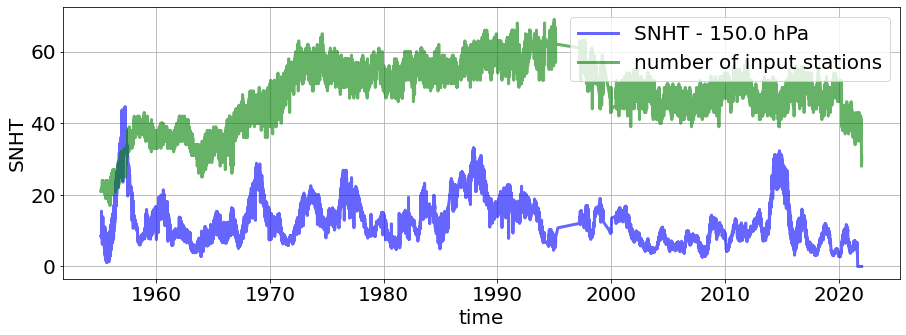

200.0


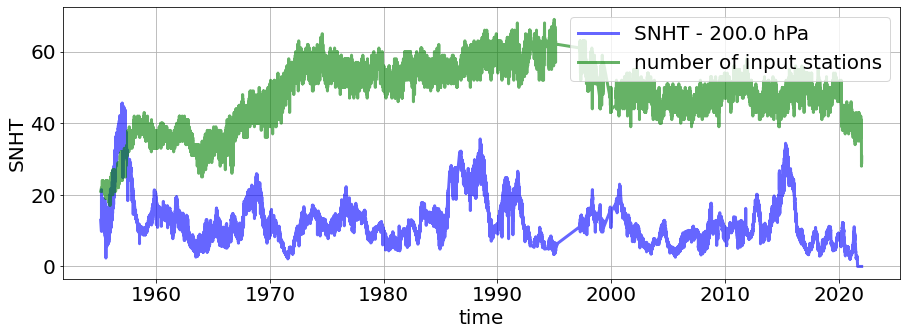

250.0


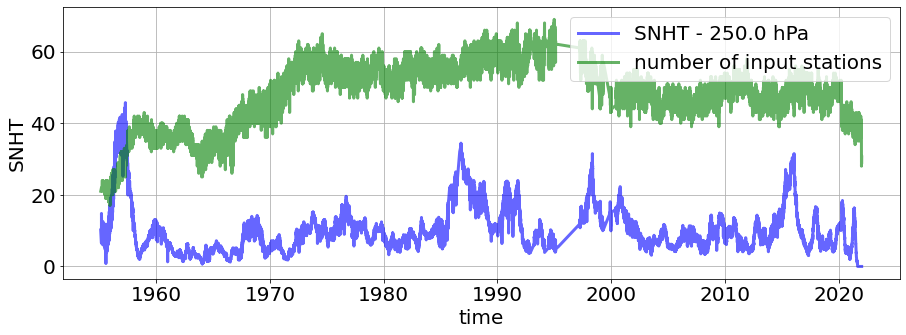

300.0


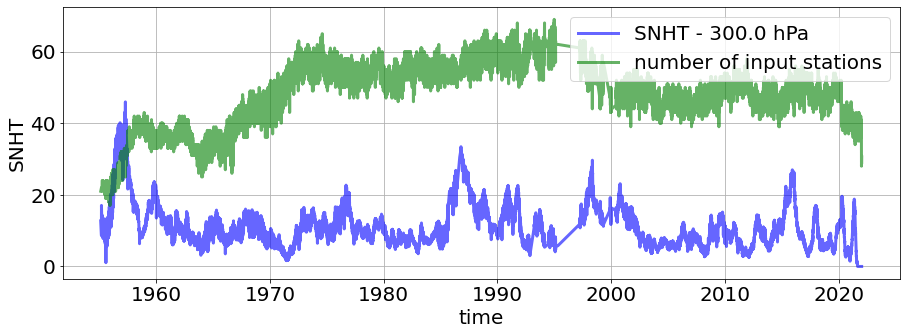

400.0


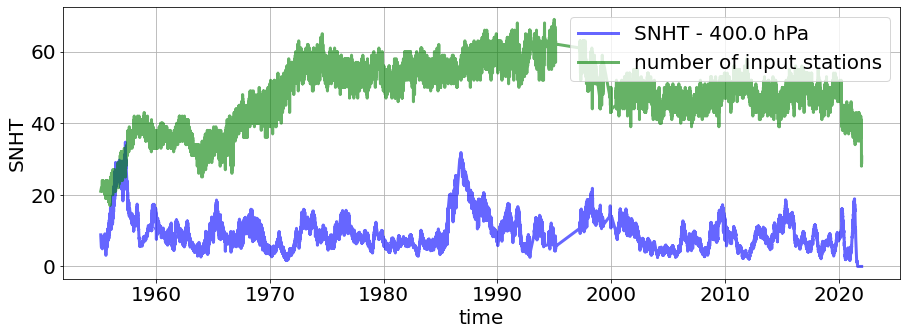

500.0


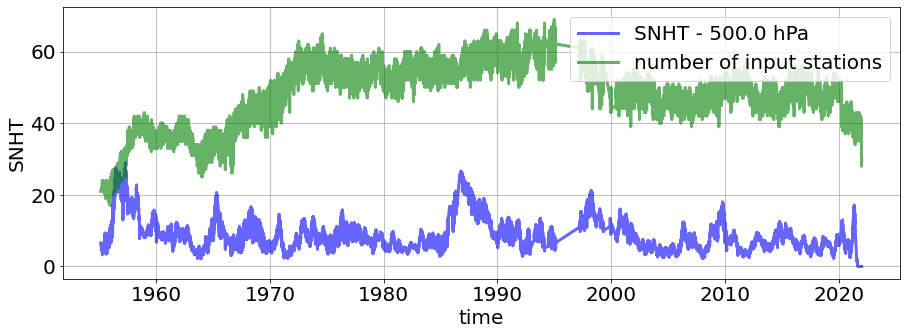

700.0


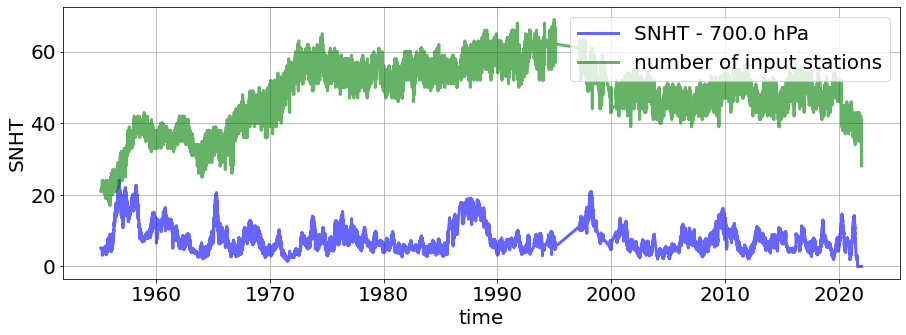

850.0


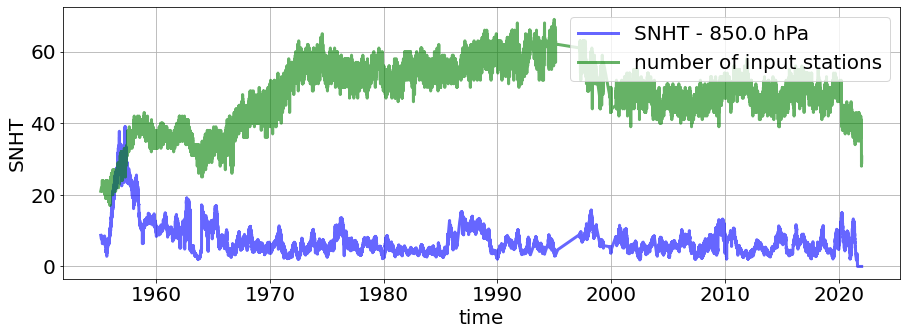

925.0


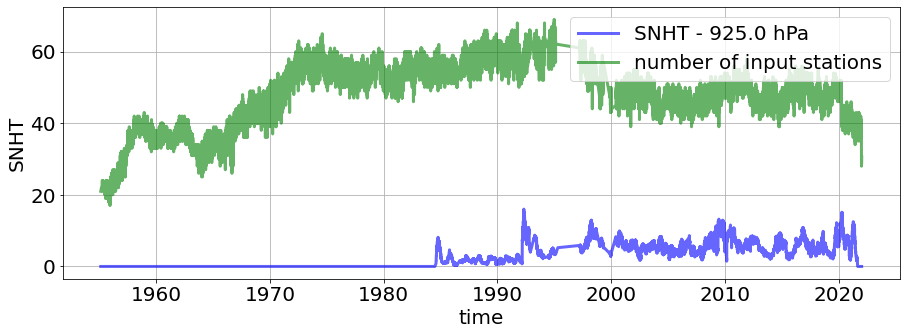

1000.0


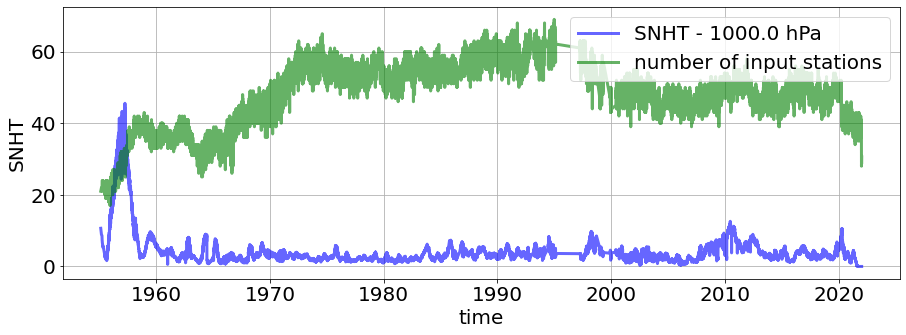

In [41]:
stdplevs = [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0]

nlen = 0
max_time = 0
for i in day_times[500]:
    if len(i) > nlen:
        max_time = i

for j in stdplevs:
    mean_snht = []
    print(j)
#     counter = 0
#     print(len(max_time))
    ic = []
    for i in max_time:
#         if (counter % 100) == 0: print(counter)
#         counter += 1
        summerizer = []
        inputcounter = 0
        for h in range(len(day_save[j][:100])):
            if i in day_times[j][h]:
                summerizer.append(day_save[j][h][day_times[j][h] == i][0])
                inputcounter += 1
        if divider != 0:
            mean_snht.append(np.nanmean(summerizer))
        else:
            mean_snht.append(0)
        ic.append(inputcounter)
                
    fig, ax = maplt.subplots(1, figsize = (15,5))
    ax.plot(np.array(max_time),np.array(mean_snht),color = 'blue', alpha = 0.6, label='SNHT - ' + str(j) + ' hPa', )
    ax.plot(np.array(max_time),np.array(ic),color = 'green', alpha = 0.6, label='number of input stations', )
    ax.set_ylabel('SNHT')
    ax.set_xlabel('time')
    ax.legend(loc='upper right')
    ax.grid()
    maplt.show()
    maplt.close()

In [10]:
len(day_save[10])

1320

In [105]:
# window = 1460  # means 4 years on daily basis
# missing = 600

# files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged*')
# df = xr.open_dataset(files[0]).to_dataframe()
# plevs = np.array(df.press.drop_duplicates())
# fig, ax = maplt.subplots(len(plevs), 1, figsize = (15,40))
# for i in range(len(plevs)):
#     df_new = df[df.press == plevs[i]]
#     resort = df_new.sort_values([('time')], ascending=True)
#     snht = test(np.array(resort.temperatures), window, missing)
    
#     ax[i].plot(np.array(resort.datum),snht,color = 'blue', label='SNHT - ' + str(plevs[i]) + ' Pa', )
#     ax[i].set_ylabel('SNHT')
#     ax[i].set_xlabel('time')
#     ax[i].legend(loc='upper right')
#     ax[i].grid()

# # maplt.title('SNHT')
# maplt.show()
# maplt.close()
